## Training for ResNet50

*if using google drive, run following two cells*

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
project_dir = '/content/drive/MyDrive/master_courses/BIDH5001 Capstone/Project/\
deep-classificataon'
os.chdir(project_dir)

In [ ]:
%pip install pydicom

imports, initiating dataloaders

In [1]:
# imports
import datetime
import time
import tempfile
import warnings
import torch
import config
from dataio.dataloader import create_dataloader
from networks.resnet_classifier import resnet50_classifier
from training.evaluation import AccuracyEvaluator, LossEvaluator
from training.utility.progress_bar import ProgressBar
from training.utility.early_stopper import ValLoss as EarlyStopper
from training.utility.signal_control import SignalFileControl
import os
import re

# whenever possible, use cuda instead of cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    warnings.warn("torch is using CPU, as cuda is unavailable. this is inefficient.")
torch.set_default_device(device)

# paths to save and load state dictionary
load_sd = False
save_sd = False

bin_path = os.path.abspath("bin")
assert os.path.isdir(bin_path)

# if load_sd set True, load from state dict
sd_load_path = None
starting_epoch = 0
sd_file_pattern = r'resnet50_state_[0-9]{2}-[0-9]{2}-ep_[0-9]{2}\.pkl'
sd_epoch_pattern = r'resnet50_state_[0-9]{2}-[0-9]{2}-ep_([0-9]{2})\.pkl'
if load_sd:
    sd_files = [
        filename for filename in os.listdir(bin_path)
        if re.match(sd_file_pattern, filename)]
    sd_files.sort(reverse=True)
    if len(sd_files) > 0:
        sd_filename = sd_files[0]
        sd_load_path = os.path.join(bin_path, sd_filename) \
            if sd_filename is not None else None
        match = re.search(sd_epoch_pattern, sd_filename)
        starting_epoch = int(match.group(1))
        print(f'- loaded state from: {sd_filename}')
print(f"- starting from epoch: {starting_epoch + 1}")

# tempfile to save the model every time it reaches the best validation loss
state_dict_backup_path = tempfile.mktemp(prefix='state-dict_', suffix='.pth')

- starting from epoch: 1


preparing the training:
1. read dicoms and labels from configuration and tracking table, initiate dataloaders
2. set up criterions and optimizers, training parameters

*the data*

In [2]:
# reading from configurations
dicoms = config.dicom_paths # tracking_table['dicom_path'].to_list()
labels = config.labels

# initiate the dataloaders
dataloader_dict = create_dataloader(
    dicoms, labels,
    batch_size = 8,
    validation_size = config.validation_size,
    test_size = config.test_size,
    img_size = (224, 224),
    use_3_channels = True,
)
training_dataloader, validation_dataloader, test_dataloader = \
    (dataloader_dict.get(key) for key in ('training_dataloader', 'validation_dataloader', 'test_dataloader'))

*the model*

In [3]:
# some settings, move to config in future
learning_rate = 0.0001 # 0.00005, originally without lr scheduler
n_epoches = 7
min_epoches = 3 # minimum epoches before early stopping allowed

# the classifier model
model = resnet50_classifier.to(device=device)
# load state dict into 
if load_sd and sd_load_path:
    state_dict = torch.load(sd_load_path)
    model.load_state_dict(state_dict)

# optimizers
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=learning_rate,
#     steps_per_epoch=len(training_dataloader), epochs=n_epoches,
#     )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.25, patience=1,
    # threshold=0.05, threshold_mode='rel',
    min_lr = learning_rate / 32,
    cooldown=7,
)

# accuracy and loss evaluators
training_loss_evaluator = LossEvaluator(loss_function)
validation_loss_evaluator = LossEvaluator(loss_function)
validation_accuracy_evaluator = AccuracyEvaluator()

best_epoch, best_loss = None, None

In [ ]:
# to continue training for n_epoches
n_epoches = 4

training for resnet50 image quality classifier

In [4]:
# evaluators for training/validation loss and accuracy
# training_loss = LossEvaluator(loss_function)
# validation_loss = LossEvaluator(loss_function)
# validation_accuracy = AccuracyEvaluator()
earlystopper = EarlyStopper(tolerance=4, target=0.25)
signalstopper = SignalFileControl()

# training epoches loop
for epoch in range(n_epoches):
    current_epoch = epoch + 1 + starting_epoch
    print(f'epoch # {current_epoch}')
    progress = ProgressBar(len(training_dataloader) + len(validation_dataloader))
    epoch_start_time = time.time()
    # reset pred and actual labels after each epoch
    validation_accuracy_evaluator.reset()
    training_loss_evaluator.reset()
    validation_loss_evaluator.reset()
    
    # training network
    for images, labels in training_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_pred = model(images)
        # train loss
        training_loss = loss_function(labels_pred, labels)
        # backpropagation
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
        progress.step()
        training_loss_evaluator.append_loss(training_loss.item())
    
    # validating network
    for images, labels in validation_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_pred = model(images)
        validation_loss = loss_function(labels_pred, labels)
        progress.step()
        validation_loss_evaluator.append_loss(validation_loss.item())
        validation_accuracy_evaluator.append(labels_pred, labels)
    epoch_end_time = time.time()
    # step scheduler
    scheduler.step(validation_loss_evaluator.value())
    print(
        f'train loss: {training_loss_evaluator}  \
        validation loss: {validation_loss_evaluator}  \
        validation accuracy: {validation_accuracy_evaluator}')
    print(
        f'precision: {round(validation_accuracy_evaluator.precision(), 3)}  \
        recall: {round(validation_accuracy_evaluator.recall(), 3)}  \
        f1: {round(validation_accuracy_evaluator.f1(), 3)}')
    # the evaluators have __str__
    print(
        f'duration: {round(epoch_end_time - epoch_start_time, 2)} s  \
        learning rate: {round(scheduler.get_last_lr()[0], 9)}')
    
    # if reaching best validation loss, back up the state
    if validation_loss_evaluator.is_best():
        best_epoch = current_epoch
        best_loss = validation_loss_evaluator.value()
        if save_sd and current_epoch > 1:
            # remove existing tempfile if exists
            os.remove(state_dict_backup_path) if os.path.isfile(state_dict_backup_path) else None
            torch.save(model.state_dict(), state_dict_backup_path)
    
    # step early stopper
    earlystopper.step(validation_loss_evaluator.value())
    print('-'*75)
    if earlystopper.stop() and epoch >= min_epoches:
        print('early stopper triggered, break')
        break
    if signalstopper.stop():
        print('signalled stop')
        break

signalstopper.reset()
# update the starting epoch number
starting_epoch = current_epoch
print('-' * 75)
if best_epoch is not None:
    print(f'best validation loss: {best_loss}, epoch {best_epoch}')
    print(f'saved to temp file: {state_dict_backup_path}')
else:
    print(f'validation loss does not improve')

signal file path: C:\Users\user\AppData\Local\Temp\signal-05-09-2zsmijey
epoch # 1
train loss: 0.209          validation loss: 0.315          validation accuracy: 88.24 %
precision: -1          recall: 0.0          f1: -1
duration: 36.49 s          learning rate: 0.0001
---------------------------------------------------------------------------
epoch # 2
train loss: 0.076          validation loss: 0.302          validation accuracy: 88.24 %
precision: -1          recall: 0.0          f1: -1
duration: 113.18 s          learning rate: 0.0001
---------------------------------------------------------------------------
epoch # 3
train loss: 0.033          validation loss: 0.276          validation accuracy: 88.24 %
precision: -1          recall: 0.0          f1: -1
duration: 74.14 s          learning rate: 0.0001
---------------------------------------------------------------------------
epoch # 4
train loss: 0.027          validation loss: 0.273          validation accuracy: 88.24 %
precis

In [8]:
print(validation_accuracy_evaluator.labels_pred)
print(validation_accuracy_evaluator.labels_actual)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [9]:
model.fc

ResnetClassifier(
  (linear_layer): Linear(in_features=512, out_features=3, bias=True)
  (softmax_layer): Softmax(dim=1)
)

In [5]:
print(validation_accuracy_evaluator.labels_pred)
print(validation_accuracy_evaluator.labels_actual)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
images.shape

torch.Size([8, 3, 224, 224])

In [6]:
images.dtype, labels.dtype

(torch.float64, torch.float32)

In [ ]:
from dataio.transforms import grayscale_to_rgb
images_rgb = grayscale_to_rgb(images[0])
images_rgb.shape

In [ ]:
training_dataset = dataloader_dict.get('training_dataset')
training_dataset._use_3_channels

save state dict

In [ ]:
# save model state_dicts to target path
sd_save_filename = f"resnet50_state_{datetime.datetime.now().strftime('%m-%d')}-ep_{current_epoch}.pkl"
sd_save_path = os.path.join(bin_path, sd_save_filename)
torch.save(model.state_dict(), sd_save_path)
print(f'state dict saved to path: {sd_save_path}')

calculate test set loss and accuracy

In [6]:
test_loss_evaluator = LossEvaluator(criterion=loss_function)
test_accuracy_evaluator = AccuracyEvaluator()
saliency_image = None

for images, labels in test_dataloader:
    images = images.to(device=device)
    labels = labels.to(device=device)
    labels_pred = model(images)
    test_loss = loss_function(labels_pred, labels)
    test_loss_evaluator.append_loss(test_loss)
    test_accuracy_evaluator.append(labels_pred, labels)
    # obtain a saliency image with good image quality
    if saliency_image is None and torch.argmax(labels[0]).item() == 2:
        saliency_image = images
print(f'test loss: {test_loss_evaluator}\
    test accuracy: {test_accuracy_evaluator}')
print(
    f'precision: {round(test_accuracy_evaluator.precision(), 2)}  \
    recall: {round(test_accuracy_evaluator.recall(), 2)}  \
    f1: {round(test_accuracy_evaluator.f1(), 2)}')

test loss: 0.772    test accuracy: 8.62 %
precision: 0.1      recall: 1.0      f1: 0.19


In [7]:
# function shows saliency map
def calculate_saliency_map(model, image, target_class):

    """
    Calculates the saliency map for a given image and target class.

    Args:
    model: A PyTorch model.
    image: A PyTorch tensor containing the image.
    target_class: The target class.

    Returns:
    numpy array containing the saliency map.
    """

    # Forward pass the image through the model.
    output = model(image)
    # Get the gradient of the output with respect to the input image.
    # gradient = torch.autograd.grad(output[0][target_class], image[0])
    gradient = torch.autograd.grad(
        output, image, grad_outputs=target_class.view(1,-1),
        allow_unused=True)[0][0]
    # Calculate the absolute value of the gradient.
    # saliency_map = torch.abs(gradient)
    saliency_map = torch.norm(gradient)
    # Normalize the saliency map.
    saliency_map = saliency_map / torch.max(saliency_map)
    saliency_map_np = saliency_map.detach().numpy()
    return saliency_map_np

In [8]:
# saliency_image = images[[0]]
# saliency_label_actual = labels[[0]]
saliency_image.requires_grad_()
saliency_label_pred = model(saliency_image)
saliency_label_actual = torch.Tensor([[0, 0, 1]]).to(device)
saliency_loss = loss_function(saliency_label_pred, saliency_label_actual)
saliency_loss.backward()
# _, saliency_map = torch.max(saliency_image.grad.data.abs(), dim=1)
saliency_map = saliency_image.grad.data.abs()[0][0]

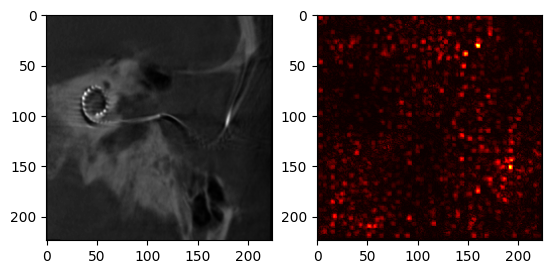

In [9]:
import matplotlib.pyplot as plt

# saliency_matrix = saliency_map[0].numpy()
_, axs = plt.subplots(nrows=1, ncols=2)
axs = axs.flatten()
axs[0].imshow(saliency_image.to('cpu')[0][0].detach().numpy(), 'binary_r')
axs[1].imshow(saliency_map.to('cpu').detach().numpy(), plt.cm.hot)
plt.show()

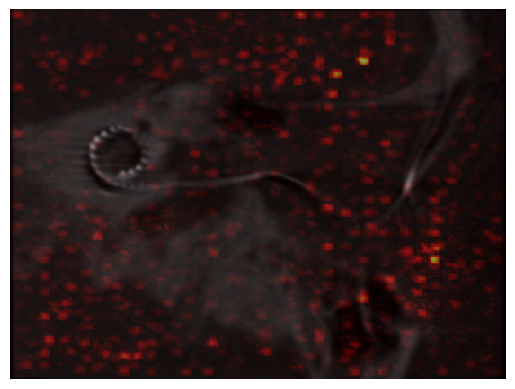

In [11]:
plt.imshow(saliency_image.to('cpu')[0][0].detach().numpy(), 'binary_r', aspect='auto')
plt.axis('off')
plt.imshow(saliency_map.to('cpu').detach().numpy(), plt.cm.hot, alpha=0.5, aspect='auto')
plt.show()

In [32]:
model.layer4[2].bn2._parameters['weight']

Parameter containing:
tensor([0.2278, 0.1785, 0.1848, 0.2385, 0.2413, 0.1762, 0.2469, 0.2349, 0.2255,
        0.2283, 0.2030, 0.2534, 0.2226, 0.2066, 0.2015, 0.2867, 0.2184, 0.2012,
        0.2188, 0.1881, 0.1831, 0.1980, 0.1802, 0.2308, 0.2480, 0.2389, 0.1964,
        0.1877, 0.2148, 0.2218, 0.1979, 0.1469, 0.3000, 0.2285, 0.2422, 0.2015,
        0.1944, 0.1975, 0.2448, 0.2005, 0.1852, 0.2079, 0.2272, 0.2191, 0.2222,
        0.2342, 0.1911, 0.2168, 0.2283, 0.2028, 0.1985, 0.1898, 0.2293, 0.2187,
        0.2065, 0.2075, 0.2222, 0.2141, 0.1967, 0.2282, 0.2184, 0.2130, 0.1901,
        0.2046, 0.2059, 0.1784, 0.1900, 0.1359, 0.2221, 0.2456, 0.2208, 0.1778,
        0.2236, 0.2088, 0.2122, 0.2278, 0.2552, 0.2030, 0.2140, 0.2262, 0.2089,
        0.1950, 0.1935, 0.2157, 0.2428, 0.1992, 0.1650, 0.2108, 0.1970, 0.2351,
        0.2062, 0.2402, 0.2241, 0.2005, 0.2331, 0.2166, 0.2167, 0.2263, 0.2556,
        0.2517, 0.1705, 0.2326, 0.2207, 0.1926, 0.2201, 0.2237, 0.1945, 0.2095,
        0.2172, 0.

In [21]:
torch.min(saliency_map)

tensor(6.6590e-08, device='cuda:0')

In [10]:
saliency_label_pred

tensor([[0.2667, 0.6983, 0.0350]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
gradient = torch.autograd.grad(output, image, grad_outputs)

In [ ]:
import matplotlib.pyplot as plt
image = images[0][0]
plt.imshow(image, cmap='binary_r')

In [ ]:
import tempfile
for images in test_dataloader.view()

In [ ]:
len(validation_accuracy_evaluator.labels_actual_raw)

## Appendix
additional details about the model

structure of the resnet_50 model

In [ ]:
model

In [ ]:
isinstance(model, torch.nn.Module)